In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms

/opt/homebrew/Caskroom/miniforge/base/envs/env_zero/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize some global variables
BATCH_SIZE = 20
STEP_SIZE = 0.01
EPOCHS = 10
DATA_ROOT = './data/cifar10'
MODEL_NAME = ['model_1', 'model_2', 'model_3']

# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("The current PyTorch install was not built with MPS enabled.")
    else:
        print("The current MacOS version is not 12.3+ and/or you do not have an"
              " MPS-enabled device on this machine.")
    DEVICE = torch.device("cpu")
else:
    DEVICE = torch.device("mps")
    print("MPS is available now.")

MPS is available now.


In [3]:
def load_data_cifar10(batch_size: 'int' = 20,
                      data_root: 'str' = './data/cifar10'):
    '''Create training, validation and test dataloader'''

    # Specify mean and std of dataset
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2470, 0.2435, 0.2616)

    # Construct transforms
    tr_transforms = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    te_transforms = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize(mean, std)])

    # Acquire training and test datasets.
    train_dataset = datasets.CIFAR10(root=data_root,
                                    train=True,
                                    download=True,
                                    transform=tr_transforms)
    valid_dataset = datasets.CIFAR10(root=data_root,
                                    train=True,
                                    download=True,
                                    transform=te_transforms)
    test_dataset = datasets.CIFAR10(root=data_root,
                                    train=False,
                                    download=True,
                                    transform=te_transforms)

    # Use 20% of training data for validation.
    train_dataset_size = int(len(train_dataset) * 0.8)
    valid_dataset_size = len(train_dataset) - train_dataset_size

    seed = torch.Generator().manual_seed(42)
    train_set, _ = torch.utils.data.random_split(
        train_dataset, [train_dataset_size, valid_dataset_size], generator=seed)
    _, valid_set = torch.utils.data.random_split(
        valid_dataset, [train_dataset_size, valid_dataset_size], generator=seed)

    # Construct data loader for training, validation and test sets.
    train_loader = torch.utils.data.DataLoader(train_set,
                                            batch_size=batch_size,
                                            shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_set,
                                            batch_size=batch_size,
                                            shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

    return train_loader, valid_loader, test_loader, mean, std

In [4]:
def exsamples_visu(dataloader,
                   geo_subplots: 'tuple' = (2, 5),
                   figsize: 'tuple' = (3, 5),
                   **kwargs):
    '''Visualize some exsamples'''

    try:
        mean = kwargs['mean']
        std = kwargs['std']
        unnormal = True
        print(f"Input data will be unnormalized.")
    except KeyError:
        unnormal = False
        print(f"Input data will be normalized.")

    try:
        label_mapping = kwargs['label_mapping']
        mapping = True
    except KeyError:
        mapping = False

    exsamples = iter(dataloader)
    images, labels = next(exsamples)
    images = images.numpy()
    labels = labels.numpy()

    _, ax = plt.subplots(geo_subplots[0],
                         geo_subplots[1],
                         sharey=True,
                         figsize=figsize)
    ax = ax.ravel()
    for i in range(np.prod(geo_subplots)):
        if unnormal:
            # Unnormalize
            img = images[i] * np.array(std)[:, None, None] + np.array(
                mean)[:, None, None]
        else:
            img = images[i]

        # Make sure the color intensity stays in range of [0, 255].
        img = (img * 255).astype(np.uint8)
        ax[i].imshow(np.transpose(img, (1, 2, 0)))
        if mapping:
            ax[i].set_title(f"{label_mapping[labels[i]]}")
        else:
            ax[i].set_title(f"{labels[i]}")

    plt.show()

In [5]:
def computing_accuracy(output, label, device):
    '''Compute accuracy of the current model.'''

    _, pred = torch.max(output, dim=1)
    pred = pred.detach().cpu().numpy(
    ) if device.type == 'mps' else pred.detach().numpy()
    label = label.detach().cpu().numpy(
    ) if device.type == 'mps' else label.detach().numpy()
    accuracy = sum(pred == label) / len(pred)
    return accuracy


def early_stopping(val_loss: 'list', error: 'float' = 0.1):
    '''Stop training if validation loss has increased.'''

    if val_loss[-1] - min(val_loss) >= error:
        print(f"Validation loss starts increasing, training will stop.")
        return True
    else:
        return False


def training_model(model,
                   optimizer,
                   criterion,
                   device,
                   epochs: 'int',
                   training: 'bool' = True,
                   **kwargs):
    '''Define a training (and testing) process.'''

    if training:
        train_loader = kwargs['train_loader']
        valid_loader = kwargs['valid_loader']
        model_name = kwargs['model_name']
    else:
        train_loader = None
        model_name = None
        valid_loader = kwargs['test_loader']

    # Record loss and accuracy
    training_loss = []
    validation_loss = []
    training_acc = []
    validation_acc = []

    for epoch in range(epochs):

        if training:
            print(f"Epoch {epoch+1}: Start training.")

            # Keep track of training loss and training accuracy
            tr_loss, tr_acc = 0.0, 0.0
            model.train()
            for (data, label) in train_loader:
                data, label = data.to(device), label.to(device)

                optimizer.zero_grad()
                tr_output = model(data)
                loss = criterion(tr_output, label)
                loss.backward()
                optimizer.step()

                tr_loss += loss.item() * data.size(0)
                tr_acc += computing_accuracy(tr_output, label,
                                             device) * data.size(0)

            # Record training loss.
            training_loss.append(tr_loss / len(train_loader.dataset))
            training_acc.append(tr_acc / len(train_loader.dataset))

        with torch.no_grad():
            if training:
                print(f"Epoch {epoch+1}: Start validating.")
            else:
                print(f"Epoch {epoch+1}: Start testing.")

            # Keep track of validation loss and validation accuracy
            val_loss, val_acc = 0.0, 0.0

            # Compute and record validation loss and validation set accuracy
            model.eval()
            for (data, label) in valid_loader:
                data, label = data.to(device), label.to(device)
                val_output = model(data)
                loss = criterion(val_output, label)
                val_loss += loss.item() * data.size(0)
                val_acc += computing_accuracy(val_output, label,
                                              device) * data.size(0)

            validation_loss.append(val_loss / len(valid_loader.dataset))
            validation_acc.append(val_acc / len(valid_loader.dataset))

            if training:
                if early_stopping(validation_loss):
                    torch.save(model.state_dict(), f'./outputs/{model_name}.pt')
                    break
                elif epoch == epochs - 1:
                    torch.save(model.state_dict(), f'./outputs/{model_name}.pt')
                    print(f"Early stopping is not implemented!")

    return [training_loss, validation_loss, training_acc, validation_acc]

In [6]:
class Model_1(nn.Module):
    '''Define an exsample CNN model.'''

    def __init__(self):
        super().__init__()
        # Convolutional layer
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class Model_2(nn.Module):
    '''Define an exsample CNN model, which should slightly better that Model_1.'''
    
    def __init__(self):
        super().__init__()
        # Convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # Dropout
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Flattening
        x = x.view(-1, 64 * 4 * 4)
        # Fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    
class Model_3(nn.Module):
    '''Define an exsample CNN model, which should slightly better that Model_2.'''

    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            # Convolutional Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Convolutional Layer block 2
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Convolutional Layer block 3
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(nn.Dropout(p=0.1), nn.Linear(4096, 1024),
                                      nn.ReLU(inplace=True),
                                      nn.Linear(1024, 512),
                                      nn.ReLU(inplace=True), nn.Dropout(p=0.1),
                                      nn.Linear(512, 10))

    def forward(self, x):
        # Convolutional layers
        x = self.conv_layer(x)
        # Flatten
        x = x.view(x.size(0), -1)
        # Fully connected layer
        x = self.fc_layer(x)
        return x

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Input data will be unnormalized.


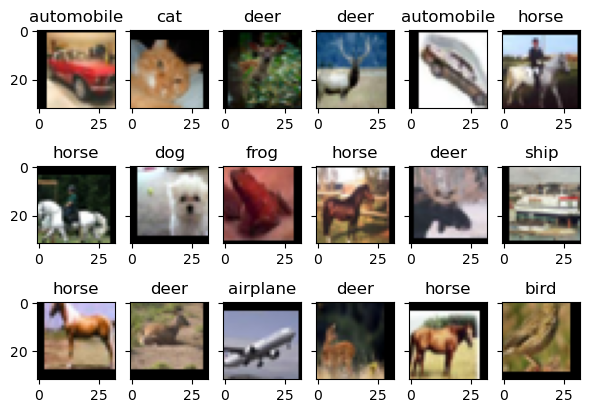

In [7]:
# Create training, validation and test dataloader
tr_loader, val_loader, te_loader, mean, std = load_data_cifar10(
    BATCH_SIZE, DATA_ROOT)

# Specify the image classes and visualize some exsamples
label_mapping = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
exsamples_visu(tr_loader,
               geo_subplots=(3, 6),
               figsize=(7, 5),
               mean=mean,
               std=std,
               label_mapping=label_mapping)

In [8]:
# Training and testing on cifar10 dataset
# Training model 1
print(f"Training model 1.")
model_1 = Model_1().to(DEVICE)
#optimizer = torch.optim.SGD(model_1.parameters(), lr=STEP_SIZE)
optimizer = torch.optim.Adam(model_1.parameters())
criterion = torch.nn.CrossEntropyLoss()

results_1 = training_model(model_1,
                           optimizer,
                           criterion,
                           DEVICE,
                           model_name=MODEL_NAME[0],
                           epochs=EPOCHS,
                           training=True,
                           train_loader=tr_loader,
                           valid_loader=val_loader)

# Training model 2
print(f"Training model 2.")
model_2 = Model_2().to(DEVICE)
#optimizer = torch.optim.SGD(model_2.parameters(), lr=STEP_SIZE)
optimizer = torch.optim.Adam(model_2.parameters())
criterion = torch.nn.CrossEntropyLoss()

results_2 = training_model(model_2,
                           optimizer,
                           criterion,
                           DEVICE,
                           model_name=MODEL_NAME[1],
                           epochs=EPOCHS,
                           training=True,
                           train_loader=tr_loader,
                           valid_loader=val_loader)

# Training model 3
print(f"Training model 3.")
model_3 = Model_3().to(DEVICE)
#optimizer = torch.optim.SGD(model_3.parameters(), lr=STEP_SIZE)
optimizer = torch.optim.Adam(model_3.parameters())
criterion = torch.nn.CrossEntropyLoss()

results_3 = training_model(model_3,
                           optimizer,
                           criterion,
                           DEVICE,
                           model_name=MODEL_NAME[2],
                           epochs=EPOCHS,
                           training=True,
                           train_loader=tr_loader,
                           valid_loader=val_loader)


Training model 1.
Epoch 1: Start training.
Epoch 1: Start validating.
Epoch 2: Start training.
Epoch 2: Start validating.
Epoch 3: Start training.
Epoch 3: Start validating.
Epoch 4: Start training.
Epoch 4: Start validating.
Epoch 5: Start training.
Epoch 5: Start validating.
Epoch 6: Start training.
Epoch 6: Start validating.
Epoch 7: Start training.
Epoch 7: Start validating.
Epoch 8: Start training.
Epoch 8: Start validating.
Epoch 9: Start training.
Epoch 9: Start validating.
Epoch 10: Start training.
Epoch 10: Start validating.
Early stopping is not implemented!
Training model 2.
Epoch 1: Start training.
Epoch 1: Start validating.
Epoch 2: Start training.
Epoch 2: Start validating.
Epoch 3: Start training.
Epoch 3: Start validating.
Epoch 4: Start training.
Epoch 4: Start validating.
Epoch 5: Start training.
Epoch 5: Start validating.
Epoch 6: Start training.
Epoch 6: Start validating.
Epoch 7: Start training.
Epoch 7: Start validating.
Epoch 8: Start training.
Epoch 8: Start val

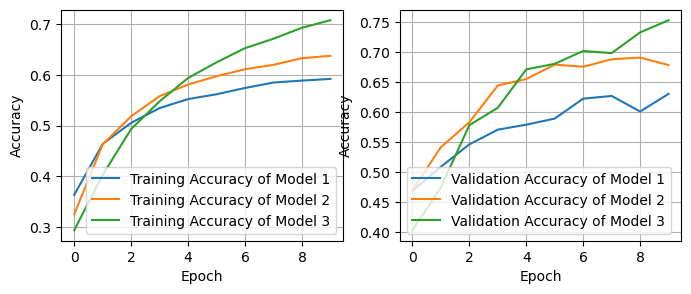

In [9]:
# Visualize validation results
_, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(results_1[2], label='Training Accuracy of Model 1')
ax[0].plot(results_2[2], label='Training Accuracy of Model 2')
ax[0].plot(results_3[2], label='Training Accuracy of Model 3')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].grid()
ax[0].legend()

ax[1].plot(results_1[3], label='Validation Accuracy of Model 1')
ax[1].plot(results_2[3], label='Validation Accuracy of Model 2')
ax[1].plot(results_3[3], label='Validation Accuracy of Model 3')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].grid()
ax[1].legend()
plt.show()

In [10]:
# Testing model 1
print(f"Testing model 1.")
model_1.load_state_dict(torch.load(f'./outputs/{MODEL_NAME[0]}.pt'))
#optimizer = torch.optim.SGD(model_1.parameters(), lr=STEP_SIZE)
optimizer = torch.optim.Adam(model_1.parameters())
criterion = torch.nn.CrossEntropyLoss()

results_1 = training_model(model_1,
                           optimizer,
                           criterion,
                           DEVICE,
                           epochs=EPOCHS,
                           training=False,
                           test_loader=te_loader)

# Testing model 2
print(f"Testing model 2.")
model_2.load_state_dict(torch.load(f'./outputs/{MODEL_NAME[1]}.pt'))
#optimizer = torch.optim.SGD(model_2.parameters(), lr=STEP_SIZE)
optimizer = torch.optim.Adam(model_2.parameters())
criterion = torch.nn.CrossEntropyLoss()

results_2 = training_model(model_2,
                           optimizer,
                           criterion,
                           DEVICE,
                           epochs=EPOCHS,
                           training=False,
                           test_loader=te_loader)

# Testing model 3
print(f"Testing model 3.")
model_3.load_state_dict(torch.load(f'./outputs/{MODEL_NAME[2]}.pt'))
#optimizer = torch.optim.SGD(model_3.parameters(), lr=STEP_SIZE)
optimizer = torch.optim.Adam(model_3.parameters())
criterion = torch.nn.CrossEntropyLoss()

results_3 = training_model(model_3,
                           optimizer,
                           criterion,
                           DEVICE,
                           epochs=EPOCHS,
                           training=False,
                           test_loader=te_loader)

# Show test results
best_acc_1 = round(max(results_1[3]) * 100, 2)
best_acc_2 = round(max(results_2[3]) * 100, 2)
best_acc_3 = round(max(results_3[3]) * 100, 2)
print(f"The best accuracy on the test set using model 1: {best_acc_1}%")
print(f"The best accuracy on the test set using model 2: {best_acc_2}%")
print(f"The best accuracy on the test set using model 3: {best_acc_3}%")


Testing model 1.
Epoch 1: Start testing.
Epoch 2: Start testing.
Epoch 3: Start testing.
Epoch 4: Start testing.
Epoch 5: Start testing.
Epoch 6: Start testing.
Epoch 7: Start testing.
Epoch 8: Start testing.
Epoch 9: Start testing.
Epoch 10: Start testing.
Testing model 2.
Epoch 1: Start testing.
Epoch 2: Start testing.
Epoch 3: Start testing.
Epoch 4: Start testing.
Epoch 5: Start testing.
Epoch 6: Start testing.
Epoch 7: Start testing.
Epoch 8: Start testing.
Epoch 9: Start testing.
Epoch 10: Start testing.
Testing model 3.
Epoch 1: Start testing.
Epoch 2: Start testing.
Epoch 3: Start testing.
Epoch 4: Start testing.
Epoch 5: Start testing.
Epoch 6: Start testing.
Epoch 7: Start testing.
Epoch 8: Start testing.
Epoch 9: Start testing.
Epoch 10: Start testing.
The best accuracy on the test set using model 1: 60.58%
The best accuracy on the test set using model 2: 66.25%
The best accuracy on the test set using model 3: 73.71%
